# Part 1: Python Scripting with GRASS

**_Corey White, Caitlin Haedrich and Vaclav Petras_**

_FOSS4G-NA 2025_

Contents:
1. [Set up GRASS environment](#1.-Set-up-GRASS-environment)
2. [Create a GRASS Python function](#2.-Scripting-with-GRASS-Tools)
3. [Convert the function to an executable script](#3.-From-Function-to-Executable-Script)

***

## 1. Set up GRASS environment

Import the Python standard libraries we need.

In [1]:
import grass.jupyter as gj
from grass.tools import Tools

Download one of the GRASS [sample projects](https://grass.osgeo.org/download/data/) using the `g.download.project` tool:

In [2]:
!grass --tmp-project XY --exec g.download.project url=https://grass.osgeo.org/sampledata/north_carolina/nc_basic_spm_grass7.tar.gz path=$HOME

Path to the project now </root/nc_basic_spm_grass7>


Start a GRASS session with `gj.init`. If not using `grass.jupyter` (i.e. writing as script as we will later), start a GRASS session with `grass.script.setup.init()`.

In [3]:
gj.init("/root/nc_basic_spm_grass7")

We've launched GRASS now! We can access GRASS GIS commands using the command line interface (with the `!` line magic):

In [4]:
!g.version

GRASS 8.5.0dev (2025)


In [5]:
!g.list type=raster

basins
elevation
elevation_shade
geology
lakes
landuse
soils


**Try it yourself**

What other data is in this project? Look at the [documentation for `g.list`](https://grass.osgeo.org/grass-devel/manuals/g.list.html) to see other options for the `type=` kwarg.

In [9]:
!g.list type=region

central_10m
state_500m


***

## 2. Scripting with GRASS Tools

GRASS functionality is available through tools. There are over 500 different tools in the core distribution and over 300 addon tools or extensions that can be used to prepare and analyze data.

Check out the [manual page](https://grass.osgeo.org/grass-devel/manuals/full_index.html) to browse tools.

We'll use the `grass.tools` Python API accessing these tools.

In [10]:
tools = Tools()

In [12]:
tools.g_version().text

'GRASS 8.5.0dev (2025)'

In [13]:
print(tools.g_region(flags="p").text)

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228500
south:      215000
west:       630000
east:       645000
nsres:      10
ewres:      10
rows:       1350
cols:       1500
cells:      2025000


In [21]:
print(tools.g_region(raster="elevation", format="json", flags="p"))

ToolResult(returncode=0, stdout='{
    "north": 228500,
    "south": 215000,
    "west": 630000,
    "east": 645000,
    "nsres": 10,
    "ewres": 10,
    "rows": 1350,
    "cols": 1500,
    "cells": 2025000,
    "crs": {
        "name": "Lambert Conformal Conic",
        "type": "other",
        "type_code": 99,
        "zone": null
    }
}
', stderr='')


### Check out our data

In [23]:
layers = tools.g_list(type="all", format="shell", flags="t").text  # flags="t"
print(layers)

raster/basins
raster/elevation
raster/elevation_shade
raster/geology
raster/lakes
raster/landuse
raster/soils
region/central_10m
region/state_500m
vector/boundary_region
vector/boundary_state
vector/census
vector/elev_points
vector/firestations
vector/geology
vector/geonames
vector/hospitals
vector/points_of_interest
vector/railroads
vector/roadsmajor
vector/schools
vector/streams
vector/streets
vector/zipcodes


`grass.jupyter.Map()` creates and displays GRASS maps as PNG images. Similar to `grass.tools`, `gj.Map()` accepts any GRASS display module as a method by replacing the "." with "_" in the module name. For example:

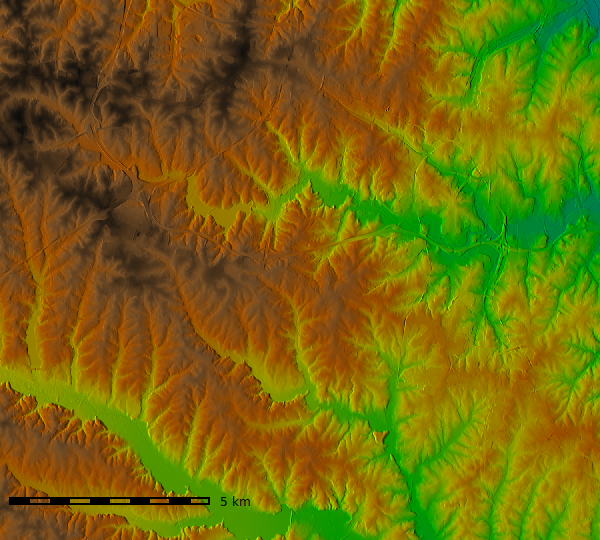

In [ ]:
example = gj.Map(use_region=True)
example.d_shade(shade="elevation_shade", color="elevation")
example.d_barscale(bgcolor="none")  # d.barscale
example.show()

To display the image, we call the `show()` method. You can also save the image with the `save()` method.

**Try it yourself**

Add a legend to the map above. Try using `d.rast` to display the elevation raster without the shading. Save the map as a png.

<details>
    <summary>👉 <b>click to see solution</b></summary>
    
```python
# To display a legend
example.d_legend(raster="elevation", flags="b", fontsize="10")  # d.legend

# To display the elevation raster
example.d_rast(map="elevation")  # d.rast map=elevation

# To save the map
example.save("example.png")
```
</details>


`grass.jupyter.InteractiveMap()` creates leaflet maps that are interactive. They can also be saved as html with the `save()` method and embedded on a website or shared.

In [32]:
map = gj.InteractiveMap()
map.add_raster("elevation", opacity=0.6)
map.show()

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

### Building a function

We're going to use [r.sim.water](https://grass.osgeo.org/grass-devel/manuals/r.sim.water.html) to model overland flow. The `r.sim.water` tool is the GRASS implementation of the SIMWE model ([Mitas and Mitasova, 1998](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/97WR03347)), a monte carlo path-tracing approach to solving the St. Venant equations for overland flow.

First, we'll shrink our computational region by shrinking each edge by a few kilometers.

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      227000
south:      220500
west:       633500
east:       641000
nsres:      10
ewres:      10
rows:       650
cols:       750
cells:      487500


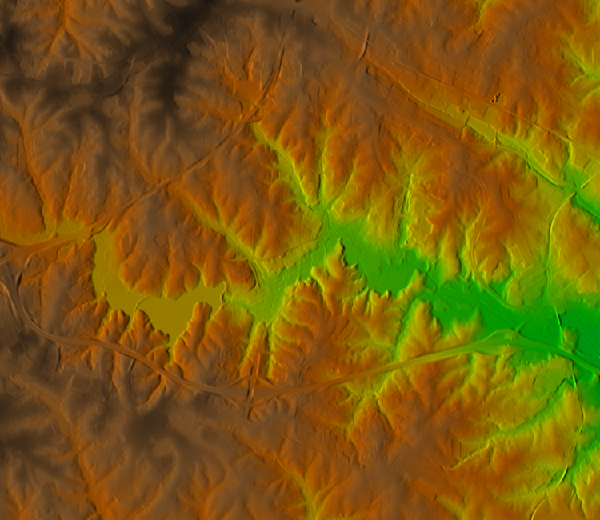

In [33]:
print(tools.g_region(s="s+5500", n="n-1500", w="w+3500", e="e-4000", flags="p").text)

example = gj.Map(use_region=True)
example.d_shade(shade="elevation_shade", color="elevation")
example.show()

Now, run SIMWE:

In [34]:
tools.r_slope_aspect(elevation="elevation", dx="dx", dy="dy")
tools.r_sim_water(elevation="elevation", dx="dx", dy="dy", depth="depth")

Look at the result:

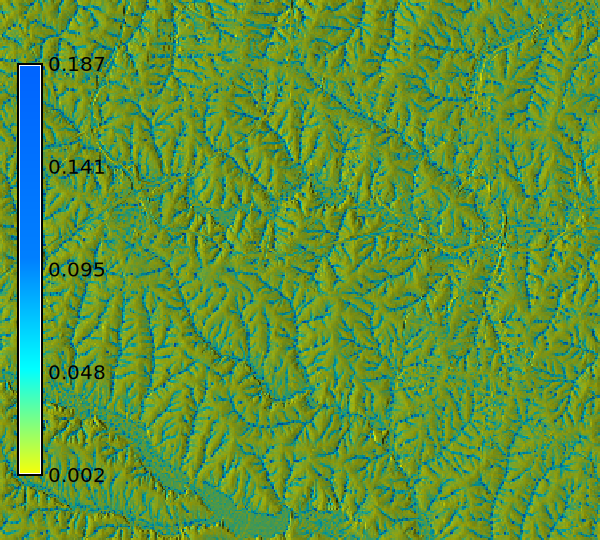

In [54]:
img = gj.Map(use_region=True)
img.d_shade(shade="elevation_shade", color="depth")
img.d_legend(raster="depth")
img.show()

If that works, let's put it into a Python function. Python function definition starts with `def` followed by a space, name of the function, parentheses which contain parameters, colon, and a function body which is an indented block of code. General syntax looks like this:

```python
def function_name(a, b):
    # code in the function, e.g.,
    return a + b
```

This function takes two parameters, adds them together with `+`, and returns the result.

Our function will have three parameters, namely elevation, rainfall_rate, and _env_. The _env_ parameter is the system environment variables which is optional here but we'll talk more about later when we start writing scripts.

Here is our function which calls _r.sim.water_:

In [37]:
def run_simwe(elevation, rainfall_rate=10, depth_output="depth"):
    tools.r_slope_aspect(elevation=elevation, dx="dx", dy="dy")
    tools.r_sim_water(
        elevation=elevation,
        dx="dx",
        dy="dy",
        rain_value=rainfall_rate,
        depth=depth_output,
    )

Our function creates new raster data, but does not return any value, so in Python, we don't need to have any `return` statement.

Calling a custom function is compltely the same as calling any other function, so:

In [38]:
run_simwe(elevation="elevation", rainfall_rate=30, depth_output="depth_30mmhr")

Check the result:

In [44]:
info = tools.r_info(map="depth_30mmhr", format="json")

In [48]:
info['mean']

0.010799927490097045

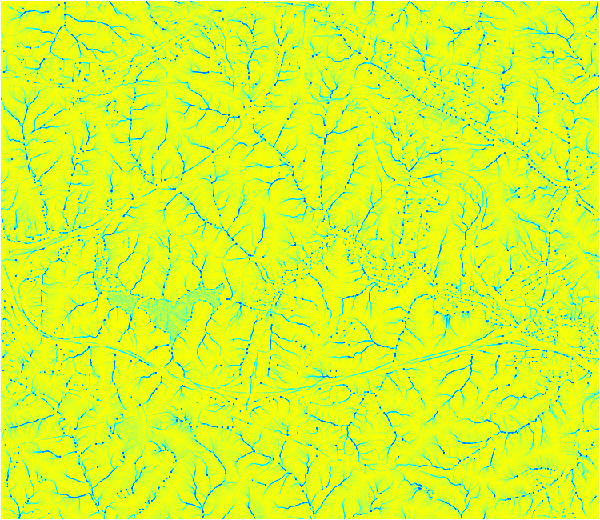

In [ ]:
img = gj.Map()
img.d_rast(map="depth_30mmhr")
img.show()

***

## 3. From Function to Executable Script

A basic Python can have a very simple structure:

In [50]:
%%python
print("Hello!")

Hello!


Here, the `%%python` line is a IPython kernel magic telling the Jupyter notebook that the cell is a content of a file which should be executed as a Python script. The Python script itself has only one line and that is `print("Hello!")`. In a text editor, you would leave out the notebook-specific  `%%python`, but here we will continue using it so that running the cell actually executes its content as a Python script.

For our non-trivial Python script, we will use a slighly more complex structure which includes `#!` line as a first line, a main function called _main_, and the call of this function in a "if-name-equals-main" block. A full, but minimal, script has these seven lines:

In [51]:
%%python
#!/usr/bin/env python3


def main():
    pass


if __name__ == "__main__":
    main()

The block which starts with `if __name__ == '__main__'` is what Python will execute when the file is used as a Python script. To keep our code organized, we call there the _main_ function. The _main_ function now contains only `pass` which means tells Python to do nothing. We will replace this `pass` statement with our code. In a script we will create, all code we want to execute will be in the _main_ function, but we will also create other functions and call them from the _main_ function.

Finally, the `#!` line is called a shebang and is used on Linux and macOS and we won't be interacting with it. Note, again, that the `%%python` line is specific to Jupyter and it is not a part of the actual script.

#### GRASS Function to GRASS Script

Now, we add the _run_simwe_ function we have defined earlier, and we add new code to the _main_ function. The complete file is:

In [53]:
%%file my_test_script.py
#!/usr/bin/env python3

import subprocess
import sys


def run_simwe(elevation, rainfall_rate=10, depth_output="depth", tools=None):
    tools.r_slope_aspect(elevation=elevation, dx="dx", dy="dy")
    tools.r_sim_water(
        elevation=elevation,
        dx="dx",
        dy="dy",
        rain_value=rainfall_rate,
        depth=depth_output,
    )


def main():
    # Append GRASS to the python system path
    sys.path.append(
        subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
    )

    import grass.script as gs
    from grass.tools import Tools

    # Initialize the GRASS session
    with gs.setup.init("/root/nc_basic_spm_grass7") as session:
        tools = Tools(session=session)
        tools.g_region(
            raster="elevation", res=40
        )  # notice res downsampling so this script runs quickly!
        run_simwe(elevation="elevation", rainfall_rate=60, tools=tools)


if __name__ == "__main__":
    main()

Writing my_test_script.py


Replace the `%%python` magic at the beginning of the cell with `%%file my_grass_script.py` to write the contents of the cell into a separate file. Now, we can call this script from the terminal!